In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta

In [7]:
train_path = "data/raw/rdu_historical_2024-08-16_to_2025-09-16.csv"
test_path = "data/raw/rdu_test_set_2025-09-17_to_2025-09-30.csv"

df = pd.read_csv(train_path, parse_dates=['time'])
df = df.rename(columns={'time': 'datetime'})
df_test = pd.read_csv(test_path, parse_dates=['time'])
df_test = df_test.rename(columns={'time': 'datetime'})

In [8]:
def add_time_features(df):
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    holidays = [
        '2025-01-01', '2025-07-04', '2025-11-27', '2025-12-25'
    ]
    df['is_holiday'] = df['datetime'].dt.strftime('%Y-%m-%d').isin(holidays).astype(int)
    return df


In [ ]:
df = add_time_features(df)
df_test = add_time_features(df_test)

feature_cols = [c for c in df.columns if c not in ['datetime', 'temperature_2m']]

In [19]:
temp_scaler = MinMaxScaler()
scaled_temp = temp_scaler.fit_transform(df[['temperature_2m']])
scaled_temp_test = temp_scaler.transform(df_test[['temperature_2m']])

X = scaled_temp
y = scaled_temp
X_test = scaled_temp_test
y_test = scaled_temp_test


In [26]:
lookback = 168
forecast_horizon = 336

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [27]:
X_input = X[-lookback:].flatten().reshape(1, -1)
preds = rf.predict(X_input)  
pred_test_scaled = preds.flatten().reshape(-1, 1)
pred_test_orig = temp_scaler.inverse_transform(pred_test_scaled).flatten()

true_test_orig = df_test['temperature_2m'].values[:forecast_horizon]

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(true_test_orig, pred_test_orig)
rmse = np.sqrt(mean_squared_error(true_test_orig, pred_test_orig))
r2 = r2_score(true_test_orig, pred_test_orig)

print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

Test MAE: 4.010, RMSE: 4.717, R²: -0.418


In [ ]:
lookback = 168   #last 7 days
forecast_horizon = 24*14  #future 14 days

def create_sliding_window(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(len(X) - lookback - horizon + 1):
        Xs.append(X[i:i+lookback].flatten())
        ys.append(y[i+lookback:i+lookback+horizon].flatten())
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sliding_window(X, y, lookback, forecast_horizon)
print("Training samples:", X_train.shape, y_train.shape)

Training samples: (8281, 168) (8281, 336)


In [24]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

X_input = X[-lookback:].flatten().reshape(1, -1)
preds = rf.predict(X_input)

pred_test_orig = temp_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
true_test_orig = df_test['temperature_2m'].values

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(true_test_orig, pred_test_orig)
rmse = np.sqrt(mean_squared_error(true_test_orig, pred_test_orig))
r2 = r2_score(true_test_orig, pred_test_orig)
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

Test MAE: 4.010, RMSE: 4.717, R²: -0.418


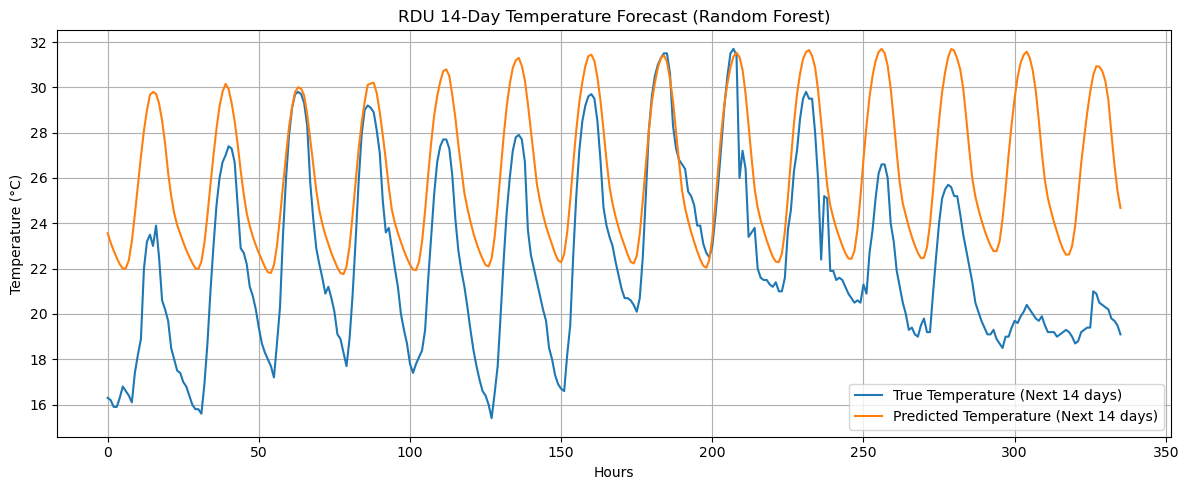

In [29]:
plt.figure(figsize=(12,5))
plt.plot(true_test_orig, label='True Temperature (Next 14 days)')
plt.plot(pred_test_orig, label='Predicted Temperature (Next 14 days)')
plt.title("RDU 14-Day Temperature Forecast (Random Forest)")
plt.xlabel("Hours")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("RF_14day_forecast_fixed.png")
plt.show()